# Introduction to 4 Tone CfL

In this experiment, we increase the number of tonal parameter from 1 to 2 per plane. The first parameter is applied to positive values while the second is used on negative values

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('#toggle').attr('value', 'Show code')  
 } else {
 $('div.input').show();
 $('#toggle').attr('value', 'Hide code') 
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggle" value="Show code"></form>''')

# Prologue

Let's start with the usual dependencies

In [1]:
%matplotlib inline

from scipy.ndimage  import imread
import matplotlib.pyplot as plt
import numpy as np

from RGB_and_YUV import conv_ycbcr
from RGB_and_YUV import conv_rgb

from cfl_utils import dc_pred
from cfl_utils import error
from cfl_utils import scale
from cfl_utils import pick_alpha
from cfl_utils import pick_alpha_pos_neg

# Load image

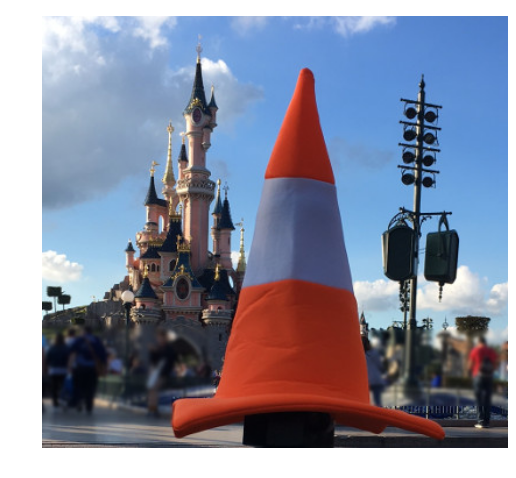

In [2]:
im = imread("images/cone.jpg")
height, width, planes = im.shape
plt.figure(figsize=(6,6))
plt.imshow(im);
plt.axis('off');

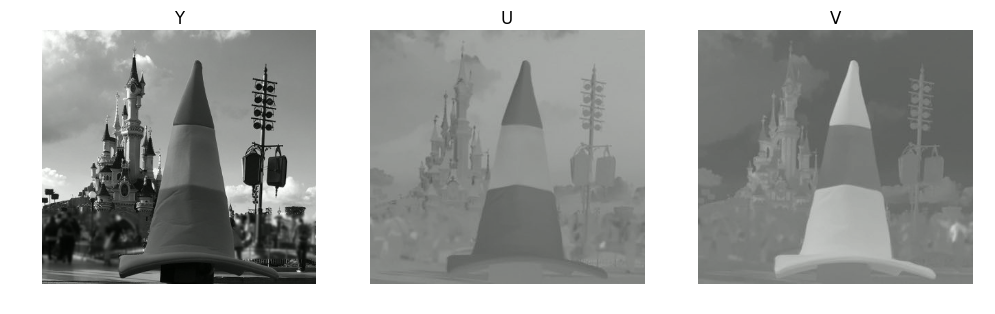

In [3]:
yuv = conv_ycbcr(im)
y = yuv[:,:,0]
u = yuv[:,:,1]
v = yuv[:,:,2]
gray = np.ones((height, width)) * 127

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(conv_rgb(np.dstack([y, gray, gray])))
plt.title("Y")
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(conv_rgb(np.dstack([u, gray, gray])))
plt.title("U")
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(conv_rgb(np.dstack([v, gray, gray])))
plt.title("V")
plt.axis('off');

# Chosen block

I chose this block because it's problematic for intra coding. As we will see DC_PRED will be terrible because it will try to average blue and orange. Other directional modes will not do much better because very few neighbors are orange.

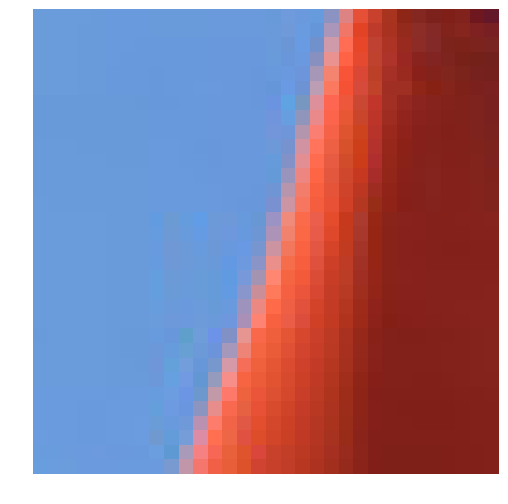

In [4]:
block_size = 32

best_x = 200
best_y = 50

block_y = y[best_y:best_y + block_size, best_x:best_x+block_size]
block_u = u[best_y:best_y + block_size, best_x:best_x+block_size]
block_v = v[best_y:best_y + block_size, best_x:best_x+block_size]

plt.figure(figsize=(6,6))
plt.imshow(conv_rgb(np.dstack([block_y, block_u , block_v])), interpolation="nearest")
plt.axis('off');

# Luma Reconstruction

We will reuse the luma block as the luma reconstructed block, since we want to focus on chroma.

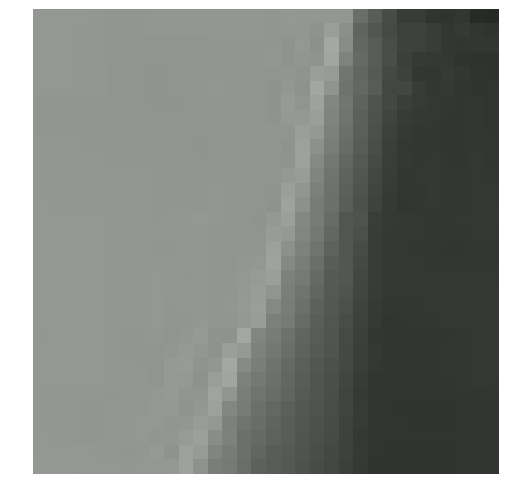

In [5]:
block_gray = np.ones((block_size, block_size)) * 127

plt.figure(figsize=(6,6))
plt.imshow(conv_rgb(np.dstack([block_y, block_gray , block_gray])), interpolation="nearest")
plt.axis('off');

# AC Contribution
By subtracting the mean, the ac contribution will be separated in positive, zero and negative values. It is reasonable to assume that high positive value and high negative values belong to different colors and should use different scaling parameters.

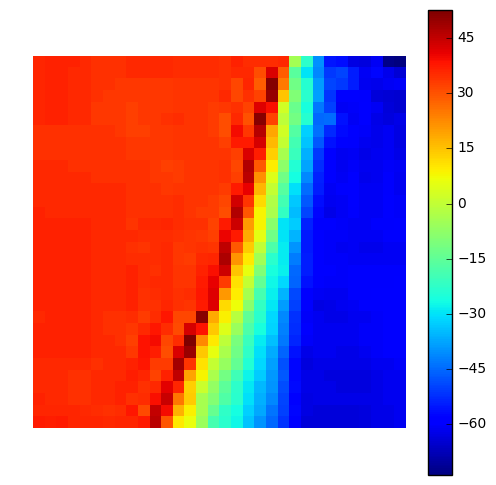

In [6]:
ac_con = block_y - block_y.mean()

plt.figure(figsize=(6,6))
plt.imshow(ac_con, interpolation="nearest")
plt.axis('off');
plt.colorbar();

# Chroma DC_PRED

As expected, the chroma DC_PRED is moslty blue, yet not the right blue, as some neighbors are orange.

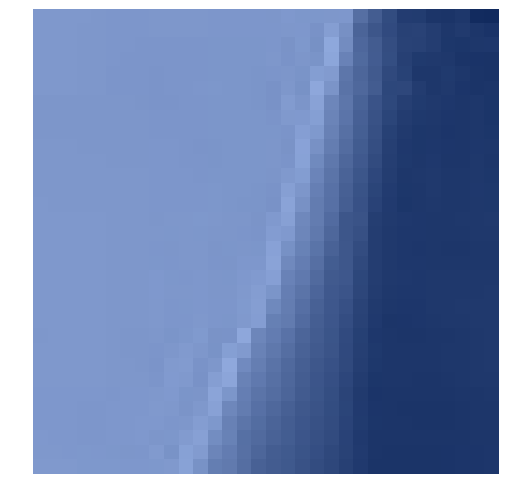

In [7]:
dc_pred_u = dc_pred(u, best_x, best_y, block_size)
block_dc_pred_u = np.ones((block_size, block_size)) * dc_pred_u

dc_pred_v = dc_pred(v, best_x, best_y, block_size)
block_dc_pred_v = np.ones((block_size, block_size)) * dc_pred_v

plt.figure(figsize=(6,6))
plt.imshow(conv_rgb(np.dstack([block_y, block_dc_pred_u, block_dc_pred_v])), interpolation="nearest")
plt.axis('off');

# CfL Prediction

CfL prediction does a little better. The blue is closer and it almost looks like there's some orange in the cone.

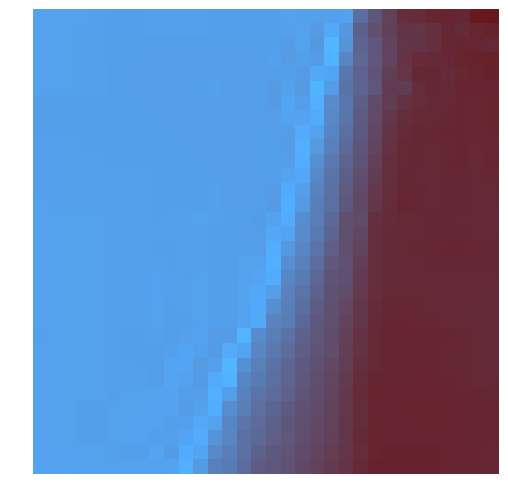

In [8]:
mags = np.arange(-2, 2, 0.125)
best_a_u, best_a_v = pick_alpha(ac_con, mags, block_size, dc_pred_u, dc_pred_v, block_u, block_v)

plt.figure(figsize=(6,6))
cfl_u = ac_con * best_a_u + dc_pred_u 
cfl_v = ac_con * best_a_v + dc_pred_v
plt.imshow(conv_rgb(np.dstack([block_y, cfl_u, cfl_v])),interpolation="nearest")
plt.axis('off');

# 4 Tone CfL Prediction
In this version of CfL, we search for a positive and a negative scaling value in each plane.

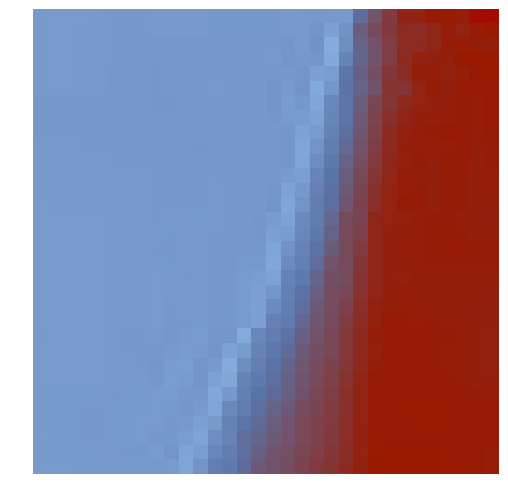

In [9]:
a_pos_u, a_neg_u, a_pos_v, a_neg_v = pick_alpha_pos_neg(ac_con, mags, block_size, dc_pred_u, dc_pred_v, block_u, block_v)
cfl4t_u = scale(ac_con, a_pos_u, a_neg_u, block_size) + dc_pred_u
cfl4t_v = scale(ac_con, a_pos_v, a_neg_v, block_size) + dc_pred_v

plt.figure(figsize=(6,6))
plt.imshow(conv_rgb(np.dstack([block_y, cfl4t_u, cfl4t_v])), interpolation="nearest")
plt.axis('off');

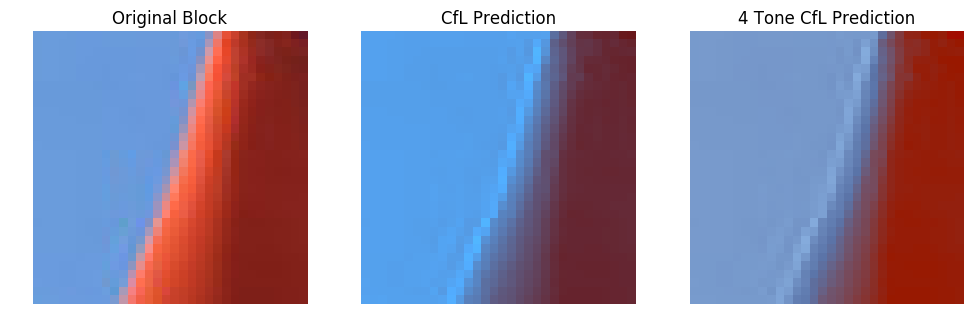

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(conv_rgb(np.dstack([block_y, block_u , block_v])), interpolation="nearest")
plt.title("Original Block")
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(conv_rgb(np.dstack([block_y, cfl_u, cfl_v])), interpolation="nearest")
plt.title("CfL Prediction")
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(conv_rgb(np.dstack([block_y, cfl4t_u, cfl4t_v])), interpolation="nearest")
plt.title("4 Tone CfL Prediction")
plt.axis('off');